In [53]:
#Uncomment out if you dont have the two libraries below

# !pip install mlfinlab
# !pip install pyfolio

In [56]:
#Import the necessary libraries
import pandas as pd
import pandas_datareader.data as dr
import matplotlib
import matplotlib.pyplot as plt
import math
import statsmodels.tsa.stattools as ts
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [57]:
start_date = '2013-01-01'
# end_date = '2020-02-29'

assets = 'FDN'
datasets = dr.DataReader(assets, data_source='yahoo', start = start_date)
datasets.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-04,195.149994,182.259995,193.559998,189.710007,2335500.0,189.710007
2020-09-08,188.279999,182.429993,182.800003,183.649994,950400.0,183.649994
2020-09-09,189.419998,184.389999,187.160004,188.250000,1768300.0,188.250000
2020-09-10,191.610001,183.809998,190.009995,184.479996,784500.0,184.479996
2020-09-11,186.350006,180.440002,185.820007,182.649994,1297600.0,182.649994


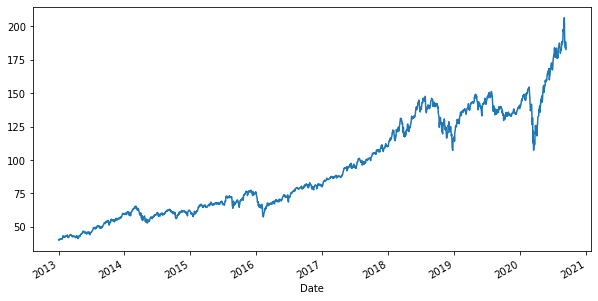

In [58]:
datasets['Adj Close'].plot(figsize=(10,5))

In [59]:
# generate SMA crossover trend predictions

# compute moving averages
fast_window = 20
slow_window = 50

datasets['fast_mavg'] = datasets['Adj Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
datasets['slow_mavg'] = datasets['Adj Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# Compute sides
datasets['side'] = np.nan

# create signal
long_signals = datasets['fast_mavg'] >= datasets['slow_mavg'] 
short_signals = datasets['fast_mavg'] < datasets['slow_mavg'] 
datasets.loc[long_signals, 'side'] = 1
datasets.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
datasets['side'] = datasets['side'].shift(1)

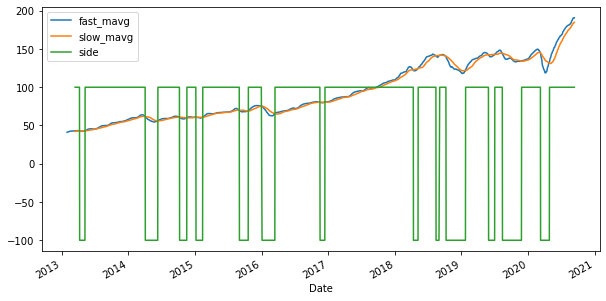

In [60]:

datasets['fast_mavg'].dropna().plot(figsize=(10,5))
datasets['slow_mavg'].dropna().plot()
(datasets['side']*100).dropna().plot()
plt.legend();

In [61]:
orig_data = datasets.copy()

# Drop the NaN values from our data set
datasets.dropna(axis=0, how='any', inplace=True)

print("1.0 --> Long Signals")
print("-1.0 --> Short Signals")
print("--------------------")
print(datasets['side'].value_counts())

1.0 --> Long Signals
-1.0 --> Short Signals
--------------------
 1.0    1429
-1.0     459
Name: side, dtype: int64


In [62]:
import mlfinlab as ml

# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=datasets['Adj Close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(datasets['Adj Close'], threshold=daily_vol.mean() * 0.5)

t_events = cusum_events

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=t_events, close=datasets['Adj Close'], num_days=1)

pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=datasets['Adj Close'],
                                               t_events=t_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=datasets['side'])
labels = ml.labeling.get_bins(triple_barrier_events, datasets['Adj Close'])
labels.side.value_counts()

2020-09-13 21:11:28.861161 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


 1.0    691
-1.0    272
Name: side, dtype: int64

In [98]:
labels

,ret,trgt,bin,side
2013-03-19,0.011067,0.005413,1,1.0
2013-03-20,-0.003726,0.009193,0,1.0
2013-03-27,0.003723,0.007972,0,1.0
2013-04-01,-0.001638,0.007895,0,1.0
2013-04-03,0.001665,0.008828,0,1.0
...,...,...,...,...
2020-09-03,-0.029815,0.023113,0,1.0
2020-09-04,-0.031944,0.028649,0,1.0
2020-09-08,0.025048,0.028986,0,1.0
2020-09-09,-0.020027,0.028493,0,1.0


In [97]:
cusum_events

DatetimeIndex(['2013-03-19', '2013-03-20', '2013-03-27', '2013-04-01',
               '2013-04-03', '2013-04-10', '2013-04-15', '2013-04-16',
               '2013-04-17', '2013-04-18',
               ...
               '2020-08-26', '2020-08-31', '2020-09-01', '2020-09-02',
               '2020-09-03', '2020-09-04', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11'],
              dtype='datetime64[ns]', length=964, freq=None)

In [96]:
vertical_barriers

2013-03-19   2013-03-20
2013-03-20   2013-03-21
2013-03-27   2013-03-28
2013-04-01   2013-04-02
2013-04-03   2013-04-04
                ...    
2020-09-03   2020-09-04
2020-09-04   2020-09-08
2020-09-08   2020-09-09
2020-09-09   2020-09-10
2020-09-10   2020-09-11
Name: Date, Length: 963, dtype: datetime64[ns]

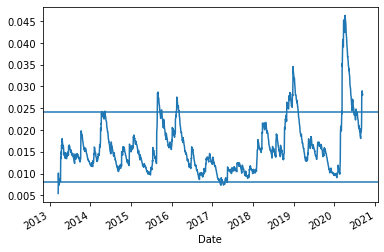

In [63]:
daily_vol.plot()
plt.axhline(daily_vol.mean()*1.5)
# plt.axhline(daily_vol.mean())
plt.axhline(daily_vol.mean()*0.5);


In [64]:
len(cusum_events)

964

In [65]:
daily_vol.mean()

0.016081341559257886

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       877
           1       0.09      1.00      0.16        86

    accuracy                           0.09       963
   macro avg       0.04      0.50      0.08       963
weighted avg       0.01      0.09      0.01       963

Confusion Matrix
[[  0 877]
 [  0  86]]

Accuracy
0.0893042575285566


In [67]:
#FEATURES:
#Momentum: Price Rate of Change, Moving Average Convergence-Divergence, Macd Threshould
#Volatility: Rolling Standard Deviation
#Correlation: Serial (Auto) Correlation
#Returns: Log_returns

# Feature generation

datasets = orig_data

datasets['log_ret'] = np.log(datasets['Adj Close']).diff()

# Momentum
datasets['mom2'] = datasets['Adj Close'].pct_change(periods=2)

## Moving Average Convergence-Divergence ##

ewma_26 = datasets['Adj Close'].transform(lambda x: x.ewm(span = 26).mean())
ewma_12 = datasets['Adj Close'].transform(lambda x: x.ewm(span = 12).mean())

macd = ewma_12 - ewma_26

threshold = macd.ewm(span = 9).mean()

datasets['cd threshold'] = threshold
datasets['MACD'] = macd

# Volatility
datasets['volatility_5'] = datasets['log_ret'].rolling(window=5, min_periods=5, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 10

datasets['autocorr_2'] = datasets['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)

# Get the various log -t returns
datasets['log_t1'] = datasets['log_ret'].shift(1)

# Re compute sides
datasets['side'] = np.nan

long_signals = datasets['fast_mavg'] >= datasets['slow_mavg']
short_signals = datasets['fast_mavg'] < datasets['slow_mavg']

datasets.loc[long_signals, 'side'] = 1
datasets.loc[short_signals, 'side'] = -1

# Remove look ahead bias
datasets = datasets.shift(1)

# Get features at event dates
X = datasets.loc[labels.index, :]

# Drop unwanted columns
X.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'fast_mavg', 'slow_mavg', 'side'], axis=1, inplace=True)

y = labels['bin']

In [99]:
y

2013-03-19    1
2013-03-20    0
2013-03-27    0
2013-04-01    0
2013-04-03    0
             ..
2020-09-03    0
2020-09-04    0
2020-09-08    0
2020-09-09    0
2020-09-10    0
Name: bin, Length: 963, dtype: int64

###TRAINING FEATURES AND MODELING (RANDOM FOREST ENSEMBLE ALGORITHM)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle


# Split data into training, validation and test sets
X_training_validation = X[start_date:end_date]
y_training_validation = y[start_date:end_date]
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.30, shuffle=False)

train_df = pd.concat([y_train, X_train], axis=1, join='inner')

train_df['bin'].value_counts()

0    549
1     60
Name: bin, dtype: int64

In [69]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    549
0    549
Name: bin, dtype: int64

In [70]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [78]:
nest = [int(x) for x in np.linspace(100,1000,11)]

In [79]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

nest = [int(x) for x in np.linspace(100,1000,11)]

parameters = {'max_depth':list(range(4,20)),
              'n_estimators':nest,
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [80]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.86657829 0.86877751 0.86922334 0.87169417 0.87065725 0.87004357
 0.8705365  0.86921031 0.86975256 0.87033333 0.87061005 0.92812375
 0.93037065 0.93002627 0.93206729 0.9319866  0.93248793 0.93345468
 0.93373121 0.93353334 0.93381055 0.93428949 0.96477067 0.96572555
 0.96860351 0.96989263 0.96965172 0.96913476 0.96857995 0.96901835
 0.96896362 0.96874993 0.96921612 0.9802934  0.98177171 0.98323216
 0.98478431 0.98471858 0.98441145 0.98463856 0.98463837 0.98459715
 0.98434427 0.98446434 0.99158408 0.99270247 0.99278325 0.99242314
 0.99235644 0.99219612 0.99244968 0.99240972 0.99252873 0.99214303
 0.99239544 0.99491935 0.99501298 0.99554471 0.99549075 0.99567665
 0.99567598 0.99554355 0.99562376 0.99567665 0.99570329 0.9956893
 0.99708489 0.99713923 0.9974977  0.9974978  0.99756401 0.99740485
 0.99740485 0.99739115 0.99743111 0.99731123 0.99728459 0.99802866
 0.99804198 0.99808194 0.99806862 0.99802866 0.99797567 0.99797567
 0.997936   0.99797567 0.997936   0.99790936 0.99829506 0.99826

In [67]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=512,
                       random_state=42)

### Classification report

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       578
           1       0.96      0.99      0.98       578

    accuracy                           0.98      1156
   macro avg       0.98      0.98      0.98      1156
weighted avg       0.98      0.98      0.98      1156

Confusion Matrix
[[557  21]
 [  7 571]]

Accuracy
0.9757785467128027


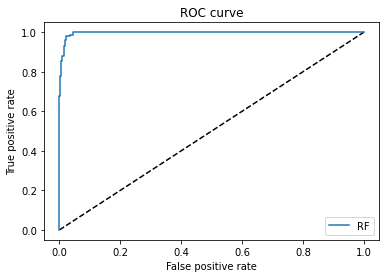

In [68]:
from sklearn.metrics import roc_curve

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       255
           1       0.16      0.30      0.21        20

    accuracy                           0.84       275
   macro avg       0.55      0.59      0.56       275
weighted avg       0.88      0.84      0.86       275

Confusion Matrix
[[224  31]
 [ 14   6]]

Accuracy
0.8363636363636363


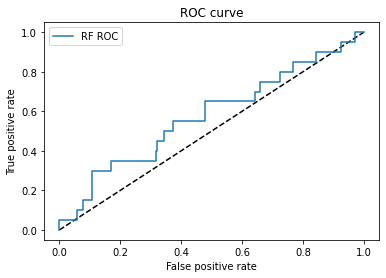

In [69]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [70]:
x_validate_min = X_validate.index.min()
x_validate_max = X_validate.index.max()
print(x_validate_min)
print(x_validate_max)

2018-03-07 00:00:00
2020-02-27 00:00:00


In [71]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(x_validate_min)
end = primary_forecast.index.get_loc(x_validate_max) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       255
           1       0.07      1.00      0.14        20

    accuracy                           0.07       275
   macro avg       0.04      0.50      0.07       275
weighted avg       0.01      0.07      0.01       275

Confusion Matrix
[[  0 255]
 [  0  20]]

Accuracy
0.07272727272727272


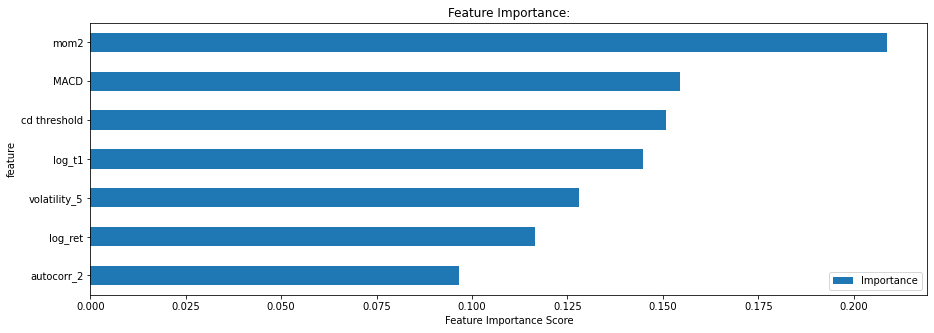

In [72]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [73]:
import pyfolio as pf

def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio.
    """
    day_val_data = 3
    intra_day_returns = intraday_returns/day_val_data
    
    cum_rets = ((intra_day_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()
    
    

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [74]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2018-03-08
End date,2020-02-27
Total months,24
,Backtest
Annual return,-4.9%
Cumulative returns,-9.8%
Annual volatility,5.6%
Sharpe ratio,-0.86
Calmar ratio,-0.42
Stability,0.50
Max drawdown,-11.6%


In [75]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2018-03-08
End date,2020-02-27
Total months,24
,Backtest
Annual return,3.3%
Cumulative returns,6.9%
Annual volatility,1.9%
Sharpe ratio,1.69
Calmar ratio,3.21
Stability,0.86
Max drawdown,-1.0%


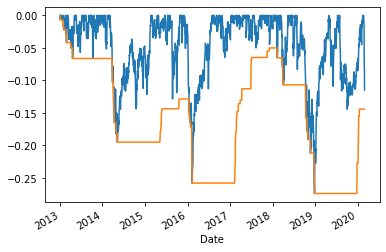

In [76]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = datasets['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = datasets['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

In [92]:
# import pyfolio as pf
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [93]:
stock_rets = pf.utils.get_symbol_rets('FB')

AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'

In [83]:
start_date = '2013-01-01'
# end_date = '2020-02-29'

assets = 'FDN'
datasets = dr.DataReader(assets, data_source='yahoo', start = start_date)['Adj Close']
datasets.tail()

Date
2020-09-04    189.710007
2020-09-08    183.649994
2020-09-09    188.250000
2020-09-10    184.479996
2020-09-11    182.649994
Name: Adj Close, dtype: float64

In [87]:
returns = datasets.pct_change().dropna()

In [88]:
returns.head()

Date
2013-01-03   -0.006474
2013-01-04    0.011028
2013-01-07    0.006445
2013-01-08   -0.005665
2013-01-09    0.003468
Name: Adj Close, dtype: float64

In [91]:
pf.create_returns_tear_sheet(returns, live_start_date='2019-12-01')

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects.